In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from mtcnn import MTCNN
import cv2

import os
import re

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertModel

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


c:\Users\gsevr\cudaenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('MELD.Raw/dev_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")
print((len(df) / 10) / 7) #aiming for 10% of the dataset with balance among emotions

15.842857142857143


In [3]:
df.Emotion.value_counts()

Emotion
neutral     470
joy         163
anger       153
surprise    150
sadness     111
fear         40
disgust      22
Name: count, dtype: int64

In [4]:
dataframes = []

for emotion in df.Emotion.unique():
    dataframes.append(df[df.Emotion == emotion].sample(16, ignore_index=True))

df = pd.concat(dataframes, ignore_index=True)
split_size = int(len(df) * 0.8)
df = df.sample(frac=1, ignore_index=True)
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,312,"Look, I'm sorry, all right.",Monica,sadness,negative,26,10,2,2,"0:11:27,853","0:11:30,865"
1,847,Really? You think so?,Rachel,fear,negative,78,7,7,22,"00:10:16,240","00:10:17,657"
2,418,Easy. Easy. You have to go to the hospital. Okay?,Ross,fear,negative,36,0,3,21,"00:15:26,342","00:15:30,345"
3,1040,I don't want a ghost.,Monica,fear,negative,97,14,3,20,"00:04:51,249","00:04:55,043"
4,444,"Well let me think about that, while I remove m...",Chandler,joy,positive,39,2,8,24,"00:01:16,439","00:01:19,484"
...,...,...,...,...,...,...,...,...,...,...,...
107,590,"But, you've got things you have to do now, and...",Joey,sadness,negative,56,11,3,22,"00:20:34,149","00:20:39,320"
108,719,"Come on guys, I-I really want this guy to like...",Ross,fear,negative,68,7,6,21,"00:02:38,449","00:02:40,742"
109,293,You've got it.,Chandler,neutral,neutral,24,6,3,11,"0:20:02,931","0:20:03,875"
110,646,"Oh. Wow! Huh. Boy! Well, someone's been do...",Ross,surprise,positive,62,2,6,16,"00:01:05,090","00:01:18,285"


In [5]:
face_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet") #include_top=True for predictions, False for embeddings


The following produces detector embeddings without the use of a NN model.

In [6]:
detector = MTCNN()

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    global face_embedding
    faces = detector.detect_faces(frame)
    face_embeddings = []
    for face in faces:
        x, y, w, h = face['box']
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, frame.shape[1]), min(y + h, frame.shape[0])
        cropped_face = frame[y1:y2, x1:x2]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/dev_splits_complete/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 2:
            ret, frame = video_capture.read()
            if not ret:
                break

            # check for more than 1 face
            if len(detector.detect_faces(frame)) == 1:

                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes
                # for face in detector.detect_faces(frame):
                #     x, y, w, h = face['box']
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = np.squeeze(single_video_embeddings)
        else:
            one_face_videos[file_name] = 'too many faces'


c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 130ms/step


In [7]:
df['many_faces'] = one_face_videos.values()
df['wrong_shape'] = [tf.constant(value).shape for value in one_face_videos.values()]

df = df[(df.many_faces != 'too many faces') & (df.wrong_shape == (2,224,224,3))]


c:\Users\gsevr\cudaenv\Lib\site-packages\pandas\core\ops\array_ops.py:131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [8]:
def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                 .strip() for txt in df['Utterance']]

C:\Users\gsevr\AppData\Local\Temp\ipykernel_4056\1250047633.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])


In [9]:
ohe = OneHotEncoder(categories=[df.Emotion.unique()])
labels = ohe.fit_transform(df.Emotion.to_numpy().reshape(-1,1)).toarray()
labels_train = labels[:split_size]
labels_val = labels[split_size:]

In [10]:
df_train = df.iloc[:split_size]
df_val = df.iloc[split_size:]

The following uses detector embeddings to fine tune the VGG16 model

In [11]:
#this includes transfer learning for vgg16 and makes predictions based on that.

for layer in face_model.layers:
    layer.trainable=False

base = face_model.output

flat = Flatten(name="flatten")(base)
fc = (Dense(256, activation='relu'))(flat)
fc_two = (Dense(64, activation='relu'))(fc)
output = (Dense(len(df.Emotion.unique()), activation='softmax'))(fc_two)
vid_pred_model = Model(inputs=face_model.input,outputs=output)

vid_pred_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

vid_train_data = []
for video in [value for value in one_face_videos.values() if tf.constant(value).shape == (2,224,224,3)]:
    video = tf.reduce_mean(video,axis=0)
    vid_train_data.append(video)

vid_train = np.array(vid_train_data)[:split_size]
vid_val = np.array(vid_train_data)[split_size:]

history_vid_pred = vid_pred_model.fit(vid_train,labels_train,epochs=10, validation_data=(vid_val,labels_val))

Epoch 1/10


c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 530s 173s/step - loss: 3.8798 - accuracy: 0.1685 - val_loss: 3.3220 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 531s 173s/step - loss: 2.6612 - accuracy: 0.2135 - val_loss: 2.4441 - val_accuracy: 0.1250
Epoch 3/10
3/3 [==============================] - 530s 173s/step - loss: 2.0603 - accuracy: 0.2809 - val_loss: 2.6519 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 530s 173s/step - loss: 1.9026 - accuracy: 0.2697 - val_loss: 2.3568 - val_accuracy: 0.1250
Epoch 5/10
3/3 [==============================] - 530s 173s/step - loss: 1.5689 - accuracy: 0.5169 - val_loss: 2.2710 - val_accuracy: 0.1250
Epoch 6/10
3/3 [==============================] - 530s 173s/step - loss: 1.3628 - accuracy: 0.5056 - val_loss: 2.2676 - val_accuracy: 0.1250
Epoch 7/10
3/3 [==============================] - 531s 173s/step - loss: 1.2000 - accuracy: 0.6854 - val_loss: 2.4697 - val_accuracy: 0.0000e+00
Epoch 8/10
3

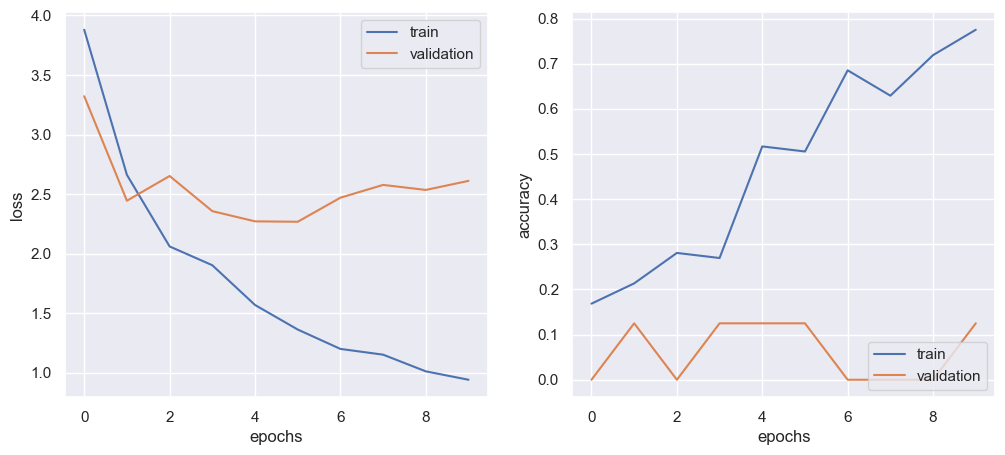

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vid_pred.history['loss'])
plt.plot(history_vid_pred.history['val_loss'])
# plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_vid_pred.history['accuracy'])
plt.plot(history_vid_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
# plt.xticks([i for i in range(0,20)])

plt.show()

In [13]:
# video predictions

video_predictions = vid_pred_model.predict(vid_val)


1/1 [==============================] - 20s 20s/step


In [14]:
df.Emotion.unique()[np.argmax(video_predictions,axis=1)]

array(['surprise', 'anger', 'sadness', 'sadness', 'sadness', 'anger',
       'sadness', 'fear'], dtype=object)

In [15]:
# this is designed to extract the embeddings from the fine tuned model

video_embedding_layers = [layer for layer in vid_pred_model.layers[:-4]]

video_embedding_model_input = vid_pred_model.input
video_embedding_model_output = video_embedding_layers[-1].output
video_embedding_model = Model(video_embedding_model_input, video_embedding_model_output)

video_embedding_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    global face_embedding
    faces = detector.detect_faces(frame)
    face_embeddings = []
    for face in faces:
        x, y, w, h = face['box']
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, frame.shape[1]), min(y + h, frame.shape[0])
        cropped_face = frame[y1:y2, x1:x2]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)


        face_embedding = video_embedding_model.predict(preprocessed_face) 
        face_embeddings.append(np.squeeze(face_embedding))
        
        return face_embeddings

# Read video
folder_path = 'MELD.Raw/dev_splits_complete/'
video_embeddings = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 2:
            ret, frame = video_capture.read()
            if not ret:
                break

            # check for more than 1 face
            if len(detector.detect_faces(frame)) == 1:

                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes
                # for face in detector.detect_faces(frame):
                #     x, y, w, h = face['box']
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = np.squeeze(single_video_embeddings)
        else:
            video_embeddings[file_name] = 'too many faces'


1/1 [==============================] - 6s 6s/step


In [31]:
#THIS GETS PREDICTIONS for text

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
token_type_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='token_type_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

bert_outputs = model(
    input_ids=input_ids,
    token_type_ids=token_type_ids,
    attention_mask=attention_mask
)

pooled_output = bert_outputs.pooler_output
dense_layer = tf.keras.layers.Dense(64, activation='relu')(pooled_output)
less_dense = tf.keras.layers.Dense(16, activation='relu')(dense_layer)
output_layer = tf.keras.layers.Dense(len(df.Emotion.unique()), activation='softmax')(less_dense)


text_pred_model = tf.keras.Model(
    inputs=[input_ids, token_type_ids, attention_mask],
    outputs=output_layer
)


# Data and labels
train_texts = list(df_train.prepro.values)
train_labels = list(labels_train)

val_texts = list(df_val.prepro.values)
val_labels = list(labels_val)

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)


# Split inputs
train_inputs = {
    'input_ids': np.array(train_encodings['input_ids']),
    'token_type_ids': np.array(train_encodings['token_type_ids']),
    'attention_mask': np.array(train_encodings['attention_mask'])
}

val_inputs = {
    'input_ids': np.array(val_encodings['input_ids']),
    'token_type_ids': np.array(val_encodings['token_type_ids']),
    'attention_mask': np.array(val_encodings['attention_mask'])
}

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_inputs,
    train_labels
)).shuffle(len(train_inputs)).batch(16,drop_remainder=True)  # Adjust batch size as needed. will return error if batch_size > len(train_inputs)

val_dataset = tf.data.Dataset.from_tensor_slices((
    val_inputs,
    val_labels
)).shuffle(len(val_inputs)).batch(5,drop_remainder=True)


# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compiling
text_pred_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'], run_eagerly=True)

# Fine-tuning
history_text_pred = text_pred_model.fit(train_dataset, epochs=3, validation_data=(val_dataset))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
5/5 [==============================] - 200s 41s/step - loss: 2.0449 - accuracy: 0.1125 - val_loss: 2.0147 - val_accuracy: 0.0000e+00
Epoch 2/3
5/5 [==============================] - 207s 42s/step - loss: 1.9579 - accuracy: 0.1875 - val_loss: 2.0822 - val_accuracy: 0.2000
Epoch 3/3
5/5 [==============================] - 203s 41s/step - loss: 1.9049 - accuracy: 0.2125 - val_loss: 1.9689 - val_accuracy: 0.2000


(8, 22)

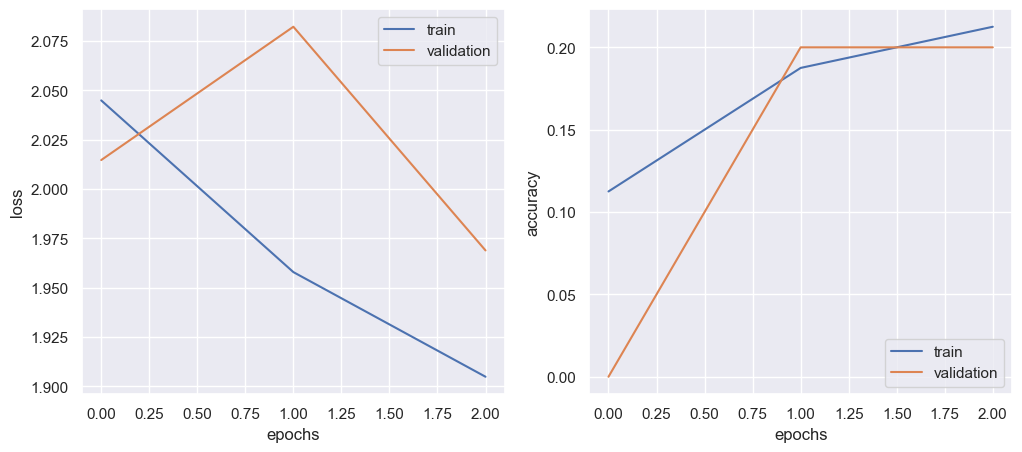

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_text_pred.history['loss'])
plt.plot(history_text_pred.history['val_loss'])
# plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_text_pred.history['accuracy'])
plt.plot(history_text_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
# plt.xticks([i for i in range(0,20)])

plt.show()

In [33]:
#Prediction format

input_texts = df_val.Utterance.values 

input_encodings = tokenizer.batch_encode_plus(input_texts, truncation=True, padding='max_length', max_length=128, return_tensors="tf")

text_predictions = text_pred_model.predict({
    'input_ids': input_encodings['input_ids'],
    'token_type_ids': input_encodings['token_type_ids'],
    'attention_mask': input_encodings['attention_mask']
})

predicted_emotions = np.argmax(text_predictions, axis=1)

emotion_labels = df.Emotion.unique() 

predicted_emotion_labels = [emotion_labels[idx] for idx in predicted_emotions]

for text, label in zip(input_texts, predicted_emotion_labels):
    print(f"Text: {text}, Predicted emotion: {label}")



c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 33s 33s/step
Text: I mean she's a very nice woman, but there is no way we can take eight weeks of her., Predicted emotion: sadness
Text: See, there's always one guy.  "If I had a wish, I'd wish for three more wishes.", Predicted emotion: sadness
Text: I know! I know! And he totally freaked out and I can't find him anywhere!, Predicted emotion: sadness
Text: But, you've got things you have to do now, and so do I., Predicted emotion: sadness
Text: Come on guys, I-I really want this guy to like me., Predicted emotion: sadness
Text: You've got it., Predicted emotion: sadness
Text: Oh.  Wow!  Huh.  Boy!  Well, someone's been doing their homework., Predicted emotion: sadness
Text: Hi!, Predicted emotion: surprise


In [34]:
# THIS GETS EMBEDDINGS

text_embeddings_model = tf.keras.Model(inputs=text_pred_model.input, outputs=bert_outputs.last_hidden_state)

text_embeddings = text_embeddings_model.predict(val_inputs)



1/1 [==============================] - 12s 12s/step


In [35]:
# con_ten = []
# video_embeddings_array = np.array([embedding for embedding in one_face_videos.values() if embedding != 'too many faces'])

# for i in range(len(df)):
#     con_ten.append(np.concatenate([text_embeddings.ravel(),video_embeddings_array.ravel()]))

# df['concat'] = con_ten

con_ten = []
video_embeddings_array = tf.reduce_mean([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])

for i in range(len(df)):
    con_ten.append(np.concatenate([text_embeddings.ravel(),video_embeddings_array.ravel()]))

df['concat'] = con_ten

C:\Users\gsevr\AppData\Local\Temp\ipykernel_4056\878274344.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  video_embeddings_array = tf.reduce_mean([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_4056\878274344.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['concat'] = con_ten


In [36]:
fusion_data = np.squeeze(np.array([con_ten]))
fusion_train = fusion_data[:split_size]
fusion_val = fusion_data[split_size:]

In [37]:
# Model for early fusion

fusion_model = Sequential()


fusion_model.add(Dense(256, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(128, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(64, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(len(df.Emotion.unique()), activation='softmax'))

fusion_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

fusion_model_history = fusion_model.fit(fusion_train,labels_train,epochs=5,validation_data=(fusion_val,labels_val))

c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 25.1046 - accuracy: 0.2247 - val_loss: 28.9510 - val_accuracy: 0.1250
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 30.8302 - accuracy: 0.1685 - val_loss: 7.1422 - val_accuracy: 0.1250
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 14.7630 - accuracy: 0.1685 - val_loss: 5.9190 - val_accuracy: 0.1250
Epoch 4/5
3/3 [==============================] - 7s 2s/step - loss: 13.0495 - accuracy: 0.1348 - val_loss: 3.6036 - val_accuracy: 0.1250
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 7.8712 - accuracy: 0.1461 - val_loss: 2.2002 - val_accuracy: 0.1250


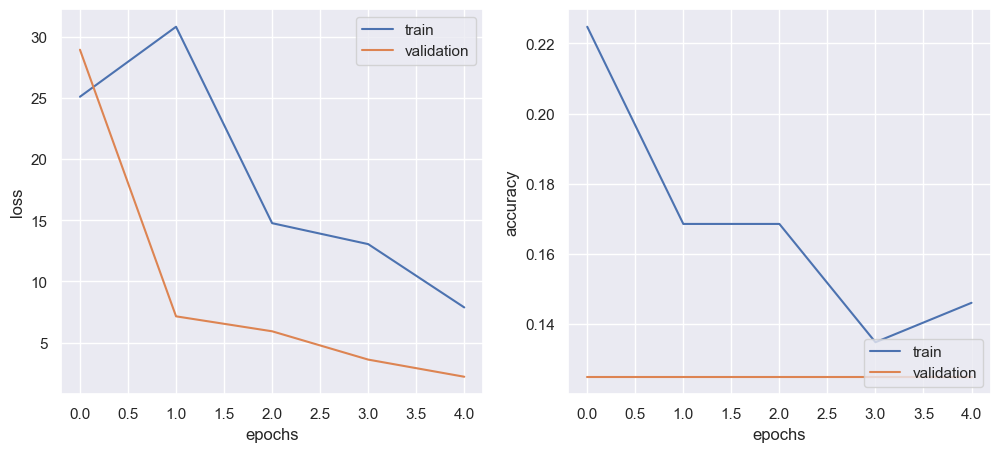

In [45]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fusion_model_history.history['loss'])
plt.plot(fusion_model_history.history['val_loss'])
# plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(fusion_model_history.history['accuracy'])
plt.plot(fusion_model_history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
# plt.xticks([i for i in range(0,20)])

plt.show()

In [39]:
fusion_model.predict(fusion_val)

1/1 [==============================] - 1s 715ms/step


array([[0.0549996 , 0.20941797, 0.1238138 , 0.34356597, 0.07067847,
        0.01736335, 0.18016078],
       [0.0549996 , 0.20941797, 0.1238138 , 0.34356597, 0.07067847,
        0.01736335, 0.18016078],
       [0.0549996 , 0.20941797, 0.1238138 , 0.34356597, 0.07067847,
        0.01736335, 0.18016078],
       [0.0549996 , 0.20941797, 0.1238138 , 0.34356597, 0.07067847,
        0.01736335, 0.18016078],
       [0.0549996 , 0.20941797, 0.1238138 , 0.34356597, 0.07067847,
        0.01736335, 0.18016078],
       [0.0549996 , 0.20941797, 0.1238138 , 0.34356597, 0.07067847,
        0.01736335, 0.18016078],
       [0.05499958, 0.20941786, 0.12381385, 0.34356606, 0.07067845,
        0.01736337, 0.18016084],
       [0.05499958, 0.20941786, 0.12381385, 0.34356606, 0.07067845,
        0.01736337, 0.18016084]], dtype=float32)

In [40]:
# Late fusion

def final_preds(text_model_predictions, visual_model_predictions, df):
    final_predictions = []

    for text_pred, vis_pred in zip(text_model_predictions, visual_model_predictions):
        text_max = np.argmax(text_pred)
        vis_max = np.argmax(vis_pred)

        # Equal predictions
        if text_max == vis_max:
            final_prediction = df.Emotion.unique()[text_max]
            print('Equal predictions')

        # Different predictions, lean towards higher confidence
        else:
            final_prediction_value = np.maximum(a := np.round(text_pred[text_max], 8), 
                                                b := np.round(vis_pred[vis_max], 8))

            try:
                print(f'Text: {a}, Visual: {b}')
                final_prediction = df.Emotion.unique()[np.where(np.round(text_pred, 8) == final_prediction_value)[0][0]]
                print('Text wins')
            except IndexError:
                final_prediction = df.Emotion.unique()[np.where(np.round(vis_pred, 8) == final_prediction_value)[0][0]]
                print('Visual wins')

        final_predictions.append(final_prediction)

    return final_predictions


In [41]:
late_fusion_predictions = final_preds(text_predictions, video_predictions, df)

#TODO Confusion matrix

Text: 0.1988808810710907, Visual: 0.9498989582061768
Visual wins
Text: 0.19673854112625122, Visual: 0.30335357785224915
Visual wins
Equal predictions
Equal predictions
Equal predictions
Text: 0.1837548464536667, Visual: 0.2914956510066986
Visual wins
Equal predictions
Text: 0.2393643856048584, Visual: 0.21553081274032593
Text wins


In [42]:
df_train.Emotion.values

array(['sadness', 'fear', 'fear', 'fear', 'joy', 'surprise', 'disgust',
       'fear', 'sadness', 'sadness', 'surprise', 'sadness', 'surprise',
       'disgust', 'disgust', 'fear', 'surprise', 'neutral', 'neutral',
       'anger', 'fear', 'sadness', 'sadness', 'anger', 'fear', 'disgust',
       'disgust', 'neutral', 'disgust', 'surprise', 'joy', 'fear',
       'neutral', 'surprise', 'sadness', 'joy', 'anger', 'fear',
       'neutral', 'neutral', 'anger', 'disgust', 'fear', 'joy', 'neutral',
       'joy', 'sadness', 'disgust', 'sadness', 'surprise', 'surprise',
       'disgust', 'surprise', 'sadness', 'anger', 'joy', 'neutral',
       'anger', 'fear', 'sadness', 'sadness', 'surprise', 'disgust',
       'anger', 'anger', 'surprise', 'joy', 'anger', 'surprise',
       'sadness', 'surprise', 'sadness', 'disgust', 'neutral', 'joy',
       'anger', 'anger', 'neutral', 'fear', 'joy', 'fear', 'sadness',
       'disgust', 'joy', 'anger', 'neutral', 'neutral', 'anger',
       'neutral'], dtype=o

In [43]:
late_fusion_predictions

['surprise',
 'anger',
 'sadness',
 'sadness',
 'sadness',
 'anger',
 'sadness',
 'surprise']

In [44]:
from sklearn.metrics import accuracy_score

accuracy_score(df_val.Emotion.values, late_fusion_predictions)

0.125